In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as dataframe
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# import shap

import xgboost
print(xgboost.__version__)
from xgboost import XGBClassifier

import pickle
import time
import importlib

!export PYTHONPATH="/home/hendrio/amex-1M/:$PYTHONPATH"
!export PYTHONPATH="/home/hendrio/amex-1M/src/:$PYTHONPATH"


import sys
sys.path.append('/home/hendrio/amex-1M/')
sys.path.append('/home/hendrio/amex-1M/src/')

import data_manager
from data_manager import DataManager
importlib.reload(data_manager)

2.0.3


<module 'data_manager' from '/home/hendrio/amex-1M/src/data_manager.py'>

In [2]:
base_dir = "/home/hendrio/amex-1M/"
os.listdir(base_dir)

paths={
    'data': join(base_dir, 'data'),
    'src': join(base_dir, 'data', 'src'),
    'processed': join(base_dir, 'data', 'processed'),
    'datasets': join(base_dir, 'datasets1'),
    'results': join(base_dir,'results'),
    'images': join(base_dir,'images'),
    'resources': join(base_dir, 'resources'),
    
}

In [10]:
def load_amex_1m(path, file_name='amex-1M_binary-dataset-[intents-permissions-apicalls].npz'):
    data = np.load(join(path, file_name), allow_pickle=True)
    metadata = dataframe(data['metadata'], columns=data['metadata_columns'])
    
    columns_names = data['column_names']
    sha256 = data['sha256']

    # labels_ohe = OneHotEncoder().fit_transform(np.expand_dims(metadata['CLASS'].values, axis=1)).toarray()

    print(data['data'].shape, metadata.shape)

    print(metadata['CLASS'].value_counts())
    return data['data'], metadata, columns_names, sha256

def create_datasets(data, metadata):

    # X_train, X_test, y_train, y_test = train_test_split( 
        # data, metadata, 
    index_train, index_test = train_test_split(
        range(len(data)),
        test_size=0.30, 
        random_state=0, 
        shuffle=True
    )
    
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    print(len(index_train), len(index_test))
    encoder_binary = OneHotEncoder().fit(np.expand_dims(metadata['CLASS'].values, axis=1))
    
    data_dict = {
        'X_train': data[index_train],
        'y_train_metadata': metadata.iloc[index_train],
        'y_train_ohe': encoder_binary.transform(np.expand_dims(metadata['CLASS'].iloc[index_train].values, axis=1)).toarray(),
        'X_test': data[index_test],
        'y_test_metadata': metadata.iloc[index_test],
        'y_test_ohe': encoder_binary.transform(np.expand_dims(metadata['CLASS'].iloc[index_test].values, axis=1)).toarray(),
        'classes_names': ['Benign', 'Malware']
    }
    
    return data_dict

# Process datasets

In [3]:
def load_npz_dataframe(path, file_name='file.npz', process_columns=False):
    data = np.load(join(path, file_name), allow_pickle=True)
    metadata = dataframe(data['metadata'], columns=data['metadata_columns'])
    
    columns_names = data['column_names']
    # sha256 = data['sha256']
    if process_columns:
        features = dataframe(columns_names, columns=['features'])
        features = modify_column(df=features, column='features', feature_list=['intent', 'permission', 'opcode', 'apicall'])
        columns_names = features['features'].values
    # labels_ohe = OneHotEncoder().fit_transform(np.expand_dims(metadata['CLASS'].values, axis=1)).toarray()

    print(data['data'].shape, metadata.shape)

    print(metadata['CLASS'].value_counts())
    # df_data = dataframe(data['data'], columns=columns_names)
    # duplicated_columns = df_data.columns.values [df_data.columns.duplicated()]
    return dataframe(data['data'], columns=columns_names), metadata

def create_class(df, threshold):
    return np.asarray([1 if i>=threshold else 0 for i in df ])


def modify_column(df, column, feature_list=['intent', 'permission', 'opcode', 'apicall']):

    def modify_string(s):
        # Replace '_' with '::'
        s = s.lower()
        s = s.replace('_', '::', 0)
        s = s.replace('.', '/')
        s = s[::-1].replace('/', '.', 1)[::-1]
        # s = s.replace(f'{feature_name}::', f'{feature_name}s::')
        s = s.replace('()', '')
        # Replace the last '/' with '.'
        # modified_str = re.sub(r'/(?!.*\/)', '.', s)
        return s
    
    df[column] = df[column].apply(modify_string)

    for f in feature_list:
        #  print(f)
         df[column] = df[column].str.replace(f'{f}::', f'{f}s::')
    
    return df

def intersection_unique(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return np.unique(lst3)

In [4]:
dataset_name_amex = 'amex-1M-[intents-permissions-opcodes-apicalls]-chi2'
dataset_name_mh100 = 'mh100'

In [35]:
# mh100_dict = {}

# mh100_dict['data'], mh100_dict['labels_ohe'], mh100_dict['metadata'], mh100_dict['columns_names'], mh100_dict['sha256'] = load_amex_1m(
#     path=paths['resources'], 
#     file_name = f'{dataset_name_mh100}.npz'
#     )

In [30]:
mh100_data, mh100_metadata = load_npz_dataframe(
    path=paths['resources'], 
    file_name= f'{dataset_name_mh100}.npz',
    process_columns=True
    )

(101934, 24833) (101934, 9)
CLASS
0    92134
1     9800
Name: count, dtype: int64


In [31]:
amex_data, amex_metadata = load_npz_dataframe(
    path=paths['processed'], 
    file_name= f'{dataset_name_amex}.npz',
    process_columns=False
    )

(1340515, 12409) (1340515, 11)
CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [33]:
duplicaded_mh100 = mh100_data.columns.values[mh100_data.columns.duplicated()]
print(duplicaded_mh100)
mh100_data = mh100_data.drop(columns=duplicaded_mh100)

['apicalls::landroid/content/intent.touri'
 'apicalls::landroid/view/viewparent.requestdisallowintercepttouchevent'
 'apicalls::landroid/view/viewgroup.requestdisallowintercepttouchevent'
 'apicalls::landroid/widget/framelayout.requestdisallowintercepttouchevent']


In [34]:
duplicaded_amex = amex_data.columns.values[amex_data.columns.duplicated()]
amex_data = amex_data.drop(columns=duplicaded_amex)
print(duplicaded_amex)

['apicalls::landroid/content/intent.createchooser'
 'apicalls::landroid/content/intent.touri'
 'apicalls::landroid/net/connectivitymanager.getactivenetworkinfo'
 'apicalls::landroid/net/connectivitymanager.isactivenetworkmetered']


In [40]:
inner_columns = np.intersect1d(amex_data.columns.values, mh100_data.columns.values, assume_unique=False )
print(inner_columns.shape)
print(inner_columns)

dataframe(inner_columns, columns=['inner_columns']).to_csv(join(paths['resources'], 'inner_columns-mh100-amex-chi2.csv'), index=False)

(11961,)
['apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery'
 'apicalls::landroid/bluetooth/bluetoothadapter.checkbluetoothaddress'
 'apicalls::landroid/bluetooth/bluetoothadapter.closeprofileproxy' ...
 'permissions::write_settings' 'permissions::write_sync_settings'
 'permissions::write_voicemail']


In [36]:
amex_data[inner_columns]

,apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery,apicalls::landroid/bluetooth/bluetoothadapter.checkbluetoothaddress,apicalls::landroid/bluetooth/bluetoothadapter.closeprofileproxy,apicalls::landroid/bluetooth/bluetoothadapter.disable,apicalls::landroid/bluetooth/bluetoothadapter.enable,apicalls::landroid/bluetooth/bluetoothadapter.getaddress,apicalls::landroid/bluetooth/bluetoothadapter.getbluetoothleadvertiser,apicalls::landroid/bluetooth/bluetoothadapter.getbluetoothlescanner,apicalls::landroid/bluetooth/bluetoothadapter.getbondeddevices,apicalls::landroid/bluetooth/bluetoothadapter.getdefaultadapter,...,permissions::write_apn_settings,permissions::write_calendar,permissions::write_call_log,permissions::write_contacts,permissions::write_external_storage,permissions::write_gservices,permissions::write_secure_settings,permissions::write_settings,permissions::write_sync_settings,permissions::write_voicemail
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1340511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1340512,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,1,0,0
1340513,1,1,0,0,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0


In [37]:
mh100_data[inner_columns]

,apicalls::landroid/bluetooth/bluetoothadapter.canceldiscovery,apicalls::landroid/bluetooth/bluetoothadapter.checkbluetoothaddress,apicalls::landroid/bluetooth/bluetoothadapter.closeprofileproxy,apicalls::landroid/bluetooth/bluetoothadapter.disable,apicalls::landroid/bluetooth/bluetoothadapter.enable,apicalls::landroid/bluetooth/bluetoothadapter.getaddress,apicalls::landroid/bluetooth/bluetoothadapter.getbluetoothleadvertiser,apicalls::landroid/bluetooth/bluetoothadapter.getbluetoothlescanner,apicalls::landroid/bluetooth/bluetoothadapter.getbondeddevices,apicalls::landroid/bluetooth/bluetoothadapter.getdefaultadapter,...,permissions::write_apn_settings,permissions::write_calendar,permissions::write_call_log,permissions::write_contacts,permissions::write_external_storage,permissions::write_gservices,permissions::write_secure_settings,permissions::write_settings,permissions::write_sync_settings,permissions::write_voicemail
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,1,1,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
101930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
101932,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0


In [39]:
np.array_equal(mh100_data[inner_columns].columns.values, amex_data[inner_columns].columns.values)

True

In [41]:
dataset_name_amex='amex-1M-inner'
dataset_name_mh100='mh100-inner'

In [42]:
np.savez_compressed(
    join(paths['results'], 'datasets', f'{dataset_name_amex}'), 
    data=amex_data[inner_columns].values,
    column_names =  amex_data[inner_columns].columns.values,
    metadata=amex_metadata.values,
    metadata_columns = amex_metadata.columns.values,
    classes =  amex_metadata['CLASS'].values,
    sha256 = amex_metadata['SHA256'].values
    )

In [43]:
np.savez_compressed(
    join(paths['results'], 'datasets', f'{dataset_name_mh100}'), 
    data=mh100_data[inner_columns].values,
    column_names =  mh100_data[inner_columns].columns.values,
    metadata=mh100_metadata.values,
    metadata_columns = mh100_metadata.columns.values,
    classes =  mh100_metadata['CLASS'].values,
    sha256 = mh100_metadata['SHA256'].values
    )

In [47]:
amex_metadata['SHA256']

0          F0CCCE784B9CCE014B49D309373A64445994EBFBCCA59D...
1          F0CCCEE4372536479010C93A63A7CF5A0C17DC147A88F6...
2          F0CCCFE09C1B6F4554F0786E23FEB706E320482D99B0E6...
3          F0CCD0627E09CF006004878283B24A763CE9703E2D91CD...
4          F0CCD2984D49D859DA890814B30C35EFC4E4DDA23D78C6...
                                 ...                        
1340510    FFFFFDF9B737730109BFE3A9EA0AB5970DD1F7E739F18E...
1340511    FFFFFE17C5D6AE624DC651BC17E9A69CC0B4ECD8AA2C9F...
1340512    FFFFFE7879B772AC120FF701675F5242DAF608B891F7F3...
1340513    FFFFFFA028417FD71BE9C607D6F4F43B84D7D956575958...
1340514    FFFFFFD9D23AD9BE157C7CD09B5248CDC3FFF1F49C9187...
Name: SHA256, Length: 1340515, dtype: object

In [48]:
np.intersect1d(amex_metadata['SHA256'], mh100_metadata['SHA256'])

array([], dtype=object)

# Load datasets

In [37]:
dataset_name='amex-1M-inner'
# dataset_name='mh100-inner'

In [38]:
data, metadata, columns_names, sha256 = load_amex_1m(
    path=join(paths['results'], 'datasets'), 
    file_name=f'{dataset_name}.npz'
    )

(1340515, 11961) (1340515, 11)
CLASS
0    1221421
1     119094
Name: count, dtype: int64


In [16]:
data_dict = create_datasets(data, metadata)

print(data_dict.keys())

938360 402155
dict_keys(['X_train', 'y_train_metadata', 'y_train_ohe', 'X_test', 'y_test_metadata', 'y_test_ohe', 'classes_names'])


In [17]:
import gc
import trainer
def pipeline_train_models(
    data_dict, models_list, dataset_name='amex-1M', sufix_title='original', path_save=join(base_dir, 'models'), feature_list=None):

    # for dataset_name in datasets.keys():
    #     print(f'Dataset name: {dataset_name}')
    for model_name in models_list:
        print()
        print()
        print(f'=========================================================================')
        print(f'===================== Model name: {model_name} ==========================')
        print(f'=========================================================================')
        
        experiment_name = f'{dataset_name}-{model_name}-{sufix_title}'
        print('\t',experiment_name)
        experiment_path = join(path_save, experiment_name)
        
        if os.path.exists(experiment_path):
            print(f"\tExperiment already exists. ")
            print(f'\t============================================================================================')
            print(f'\t====================== Skipping {experiment_name} =====================')
            print(f'\t============================================================================================')
            continue
        else:
            os.makedirs(experiment_path)

        X_train, X_test = [], []
        if feature_list is not None:
            X_train = data_dict['X_train'][feature_list]
            X_test = data_dict['X_test'][feature_list]
        else:
            X_train = data_dict['X_train']
            X_test = data_dict['X_test']
        print(f'\tDataset shape: Train {X_train.shape}, Test {X_test.shape}')

        print(f"\tTraining {model_name}")
        model=[]
        extension='.joblib'
        if model_name=='xgboost':
            model, time_duration = trainer.train( 
                X=X_train , y=data_dict['y_train_ohe'], model_name=model_name)
            extension='.joblib'
        elif model_name=='randomforest':
            model, time_duration = trainer.train( 
                X=X_train, y=data_dict['y_train_ohe'], model_name=model_name)
            extension='.joblib'
        elif model_name=='svm':
            model, time_duration = trainer.train( 
                X=X_train, y=data_dict['y_train_ohe'], model_name=model_name)
            extension='.joblib'
        # elif model_name=='knn':
        #     model, time_duration = trainer.train( 
        #         X=X_train, y=data_dict['y_train_ohe'], model_name=model_name)
        #     extension='.joblib'
        # elif model_name=='fcn':
        #     model, time_duration = trainer.build_deep_model(
        #         X=X_train, y=data_dict['y_train_ohe'], 
        #         num_classes=len(data_dict['classes_names']), 
        #         model_name=experiment_name, 
        #         path_experiment=experiment_path)
        #     extension='.h5'

        #     model = tf.keras.models.load_model(join(experiment_path, f'{experiment_name}_loss.keras'))
        else:
            raise Exception (f'Model Not Found on pipeline_train_models()')
            os.remove(experiment_path)
            return []

        trainer.save_model(
            model=model, 
            directory=experiment_path, 
            filename= experiment_name,
            # extension=extension
            )
        
        with open(join(experiment_path, f'{experiment_name}-time.txt'), 'w') as file:
            file.write(f'{time_duration:.4f}')
        print(f"\tEvaluating {model_name}")
        
        pred, cm, report = trainer.eval(
            X=X_test, 
            # y_true=np.argmax(y_test, axis=1), 
            y_true=data_dict['y_test_ohe'], 
            model=model,
            class_labels=data_dict['classes_names'],
            dataset_name=dataset_name,
            model_name=model_name,
            path_save=experiment_path
        )

        gc.collect()

        print('---------------------------------------------------------------------------------------------------------------')
        print('')
        print('')

    return 

In [9]:
print(dataset_name)

amex-1M-[intents-permissions-opcodes-apicalls]-chi2




===================== Model name: xgboost ==========================
	 amex-1M-inner-xgboost-houdout
	Dataset shape: Train (938360, 11961), Test (402155, 11961)
	Training xgboost
Took 3311.6311 seconds to train the xgboost
	Evaluating xgboost
(402155,) (402155,)

              precision    recall  f1-score   support

           0     0.9887    0.9951    0.9919    366364
           1     0.9462    0.8831    0.9136     35791

    accuracy                         0.9851    402155
   macro avg     0.9674    0.9391    0.9527    402155
weighted avg     0.9849    0.9851    0.9849    402155

---------------------------------------------------------------------------------------------------------------




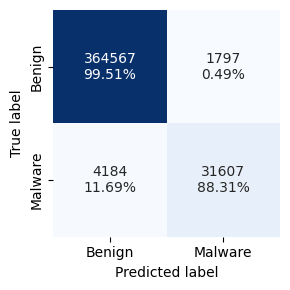

In [18]:
pipeline_train_models(
    data_dict=data_dict, 
    models_list=['xgboost'], #'knn', 'svm'
    dataset_name='amex-1M-inner', 
    sufix_title='houdout', 
    path_save=join(base_dir, 'results', 'models'),
    feature_list = None
)

# Cross Prediction

In [19]:
import joblib

In [39]:
# amex_model = joblib.load('/home/hendrio/amex-1M/results/models/amex-1M-inner-xgboost-houdout/amex-1M-inner-xgboost-houdout.joblib')
mh100_model = joblib.load('/home/hendrio/amex-1M/results/models/mh100-inner-xgboost-houdout/mh100-inner-xgboost-houdout.joblib')

In [40]:
data.shape, metadata.shape

((1340515, 11961), (1340515, 11))

In [41]:
encoder_binary = OneHotEncoder().fit(np.expand_dims(metadata['CLASS'].values, axis=1))
labels = encoder_binary.transform(np.expand_dims(metadata['CLASS'].values, axis=1)).toarray()

print(labels.shape)

(1340515, 2)


In [42]:
# pred = amex_model.predict_proba(data)
pred = mh100_model.predict_proba(data)

print(pred.shape)

(1340515, 2)


(1340515,) (1340515,)

              precision    recall  f1-score   support

           0     0.9314    0.9989    0.9640   1221421
           1     0.9561    0.2450    0.3901    119094

    accuracy                         0.9319   1340515
   macro avg     0.9437    0.6220    0.6770   1340515
weighted avg     0.9336    0.9319    0.9130   1340515



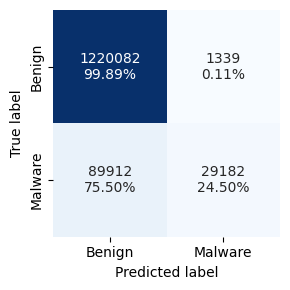

In [43]:
pred, cm, report = trainer.eval(
    X=data, 
    # y_true=np.argmax(labels, axis=1), 
    y_true=labels, 
    model=mh100_model,
    class_labels=['Benign', 'Malware'],
    dataset_name='mh100-inner',
    model_name='xgboost-holdout-cross',
    path_save='/home/hendrio/amex-1M/results/models/'
)